In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '../Scripts')
# import load_images
from load_images import load_images, get_df_paths
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

import copy

Succesfull loaded: path_list, labels, split, image_type, file_npy
Succesfull loaded: df_metadata_images


In [2]:
def gen_data(n_train, n_gen, data_gen_args, n_load = 10):
#     import random
    seed = random.randint(100,10000)
    ims = load_images(get_df_paths(n=n_load, random=False)) # Cargamos las imagenes reales
    '''Revisar este punto. Tarda mucho en cargar dataset. Valorar crear pickle.'''
#     print("ims cargadas")
    
    n_ims = ims.shape[0]
    if n_train<=1 & isinstance(n_train, float): #asumimos n_float como fracción
        n_train = int(np.round(n_ims*n_train))
    
    ims_train = ims[:n_train, :, :].astype("float16")
    ims_val = ims[n_train:, :, :].astype("float16")
    
    # Generamos el DS de train. newaxis por posterior requerimiento de DataAugmentation
    ds_train = tf.data.Dataset.from_tensor_slices((ims_train[:,:,:,np.newaxis],ims_train[:,:,:,np.newaxis]))
    ds_val = tf.data.Dataset.from_tensor_slices((ims_val[:,:,:,np.newaxis], ims_val[:,:,:,np.newaxis]))
#     print("ds_train y ds_val generados")
    
    # Generamos DS de DataAugmentation
    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    im_iter = image_datagen.flow(ims_train[:,:,:,np.newaxis], batch_size=1, seed=seed) # Iterador/Generador
    # TODO: Revisar batch_size y ims/ims_train
    def generador():
        aux_iter = im_iter.next()[0,:,:,:]
        yield aux_iter, aux_iter
        
    ds_gen = tf.data.Dataset.from_generator(generador, output_types=(tf.float16, tf.float16),
                                             output_shapes=([180,180,1], [180,180,1]))
    
    # SOME ARGUMENTS ARE DEPRECATED: (output_shapes, output_types). They will be removed in a future version. 
                                        #Instructions for updating: Use output_signature instead (no esta en esta version)
#     ds_gen = tf.data.Dataset.from_generator(lambda: im_iter, 
#                                         output_signature=tf.TensorSpec(shape=(1,180,180,1), dtype=tf.float64))
#     print("ds_gen generado")
    # Concatenamos ds_train y ds_gen, indicando cuantas imágenes se generan
    print("ds_train shape: {}\nds_gen shape: {}".format(ds_train.element_spec,ds_gen.element_spec))
    ds = ds_train.concatenate(ds_gen.take(n_gen)).filter(lambda x, y: tf.reduce_max(x)>0)
#     print("ds concatenado")
#     ds = ds.shuffle(n_train+n_gen, reshuffle_each_iteration=True) 
    '''Revisar 1er argumento si problemas con la memoria'''
    return(ds, ds_val)

In [3]:
data_gen_args = dict(
                     rotation_range=10, zoom_range=0.1)
                     # shear_range=1)
                     # width_shift_range=0.1,
                     # height_shift_range=0.1,
                     # zoom_range=0.2)
            
ds,ds_val = gen_data(0.8, 2000, data_gen_args, 0)
a=ds.as_numpy_iterator().next()
print("\n\nNum images: {}\nLength: {}\nShape: {}\nMin & Max: {} - {}\nDataset info: {}".format(
    len(list(ds.as_numpy_iterator())), len(a), a[0].shape, a[0].min(), a[0].max(), ds))

Loading data
A total of 0 images has been omited due to its max value was 0
ds_train shape: (TensorSpec(shape=(180, 180, 1), dtype=tf.float16, name=None), TensorSpec(shape=(180, 180, 1), dtype=tf.float16, name=None))
ds_gen shape: (TensorSpec(shape=(180, 180, 1), dtype=tf.float16, name=None), TensorSpec(shape=(180, 180, 1), dtype=tf.float16, name=None))


Num images: 3486
Length: 2
Shape: (180, 180, 1)
Min & Max: 0.0 - 0.73876953125
Dataset info: <FilterDataset shapes: ((180, 180, 1), (180, 180, 1)), types: (tf.float16, tf.float16)>


In [16]:
# a = ds.as_numpy_iterator().next()
lista = []
for a in ds.as_numpy_iterator():
    lista.append(a[0].max())
    if np.isnan(a[0].max()):
        print("1 NaN")
np.min(lista)

0.2769

In [63]:
lista
len(list(ds.as_numpy_iterator()))
ds.element_spec

NameError: name 'lista' is not defined

In [113]:
import random
seed = random.randint(100,10000)
n_train=0.8
n_gen=3000
n_load = 0

data_gen_args = dict(rotation_range=10, zoom_range=0.1)
    
ims = load_images(get_df_paths(n=n_load, random=False)) # Cargamos las imagenes reales
'''Revisar este punto. Tarda mucho en cargar dataset. Valorar crear pickle.'''
print("ims cargadas")

n_ims = ims.shape[0]
if n_train<=1 & isinstance(n_train, float): #asumimos n_float como fracción
    n_train = int(np.round(n_ims*n_train))

ims_train = ims[:n_train, :, :].astype("float16")
ims_val = ims[n_train:, :, :].astype("float16")

# Generamos el DS de train. newaxis por posterior requerimiento de DataAugmentation
ds_train = tf.data.Dataset.from_tensor_slices((ims_train[:,:,:,np.newaxis],ims_train[:,:,:,np.newaxis]))
ds_val = tf.data.Dataset.from_tensor_slices((ims_val[:,:,:,np.newaxis], ims_val[:,:,:,np.newaxis]))
print("ds_train y ds_val generados")

# Generamos DS de DataAugmentation
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
im_iter = image_datagen.flow(ims_train[:,:,:,np.newaxis], batch_size=1, seed=seed) # Iterador/Generador
# TODO: Revisar batch_size y ims/ims_train
def generador():
    aux_iter = im_iter.next()[0,:,:,:]
    yield aux_iter, aux_iter

ds_gen = tf.data.Dataset.from_generator(generador, output_types=(tf.float16, tf.float16), 
                                         output_shapes=([180,180,1], [180,180,1]))


ds = ds_train.concatenate(ds_gen.take(n_gen))
# a=ds_gen.as_numpy_iterator().next()
# print("Num images: {}\nLength: {}\nShape: {}\nMin & Max: {} - {}\nDataset info: {}".format(
#     len(list(ds.as_numpy_iterator())), len(a), a[0].shape, a[0].min(), a[0].max(), ds))

Loading data
ims cargadas
ds_train y ds_val generados


In [84]:
ds_train.as_numpy_iterator().next()[0].shape

(180, 180, 1)

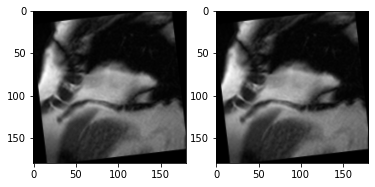

In [317]:
plt.subplot(121)
plt.imshow(a1[0,:,:,0], vmax=a1[0,:,:,0].max(),vmin=a1[0,:,:,0].min())
plt.subplot(122)
plt.imshow(a2[0,:,:,0])

In [257]:
random.randint(1,1000)

58

In [4]:
%load_ext tensorboard
import datetime


#### Custom layer to sample the codings, given μ and γ 
# μ = mean
# γ = log_var = log(sigma^2), where sigma is standard deviation
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    
    
def encoder_block(inputs, n_filters, block_name):
    """
    Custom block of layers to build the encoder
    """
    with K.name_scope(block_name):
        x = tf.keras.layers.Conv2D(filters=n_filters, strides=(2, 2), kernel_size=3, padding='same')(inputs)
#         bn = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.LeakyReLU()(x)
    return x    


def decoder_block(inputs, n_filters, block_name, padding='same'):
    """
    Custom block of layers to build the decoder
    """
    with K.name_scope(block_name):
#         x = tf.keras.layers.Dropout(rate=0.2, seed=666)(inputs)
        x = tf.keras.layers.UpSampling2D((2,2), interpolation="bilinear")(inputs)
        x = tf.keras.layers.Conv2D(filters=n_filters, strides=1, kernel_size=3, padding=padding)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Conv2D(filters=n_filters, strides=1, kernel_size=3, padding="same", use_bias=False)(x)
#         x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
    return x 


def conv_block(inputs, n_filters, block_name, padding='same'):
    """
    Custom block of layers to build the decoder
    """
    with K.name_scope(block_name):
        x = tf.keras.layers.Conv2D(filters=n_filters, strides=1, kernel_size=3, padding=padding)(inputs)
#         x = tf.keras.layers.LeakyReLU()(x)
#         x = tf.keras.layers.Conv2D(filters=n_filters, strides=1, kernel_size=3, padding="same", use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
#         x = tf.keras.layers.Conv2D(filters=n_filters, strides=1, kernel_size=3, padding="same", use_bias=True)(x)
#         x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Conv2D(filters=n_filters, strides=1, kernel_size=3, padding="same", use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        output = x
    return output 


class CVAE(tf.keras.Model):
    def __init__(self, codings_size, learning_rate=1e-3):
        super().__init__() #Ejecutamos init de tf.keras.Model
        self.codings_size = codings_size
        self.learning_rate = learning_rate
        self.initial_epoch = 0
        print("Inicializando...")
        ### Encoder
        inputs = keras.Input(shape=[180, 180, 1]) # Revisar si es necesario esto
        z = encoder_block(inputs, 4, "Encoder_1")
        z = encoder_block(z, 8, "Encoder_2")
        z = encoder_block(z, 16, "Encoder_3")
        z = encoder_block(z, 32, "Encoder_4")
        z = encoder_block(z, 64, "Encoder_5")
        z = encoder_block(z, 128, "Encoder_7")
        z = tf.keras.layers.Flatten()(z)
        # No activation
#         tf.keras.layers.Dense(latent_dim + latent_dim)(z)
        codings_mean = keras.layers.Dense(codings_size)(z) # μ
        codings_log_var = keras.layers.Dense(codings_size)(z) # γ
        codings = Sampling()([codings_mean, codings_log_var])
        self.encoder = keras.Model(
            inputs=[inputs], outputs=[codings_mean, codings_log_var, codings], name="encoder")
        print("Encoder creado")
        ### Decoder
        decoder_inputs = keras.layers.Input(shape=[codings_size])
#         final_shape = int(180/(2**5)) # shape[0] at the encoding before flatten
        print("Decoder Inputs creados")
        x = tf.keras.layers.Dense(units=6*6*64, activation=tf.nn.relu)(decoder_inputs)
        print("Decoder primera densa creada")
        x = tf.keras.layers.Reshape(target_shape=(6, 6, 64))(x)
        print("Decoder reshape hecho")
        x = decoder_block(x, 128, "Decoder_1")
        x = decoder_block(x, 64, "Decoder_2")
        x = decoder_block(x, 64, "Decoder_3", padding="valid")
        x = decoder_block(x, 32, "Decoder_4", padding="valid")
        x = decoder_block(x, 32, "Decoder_5")
        decoder_output = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(x)
        x = conv_block(x, 32, "Decoder_6")
#         x = tf.keras.layers.Concatenate()([decoder_output, x])
        x = conv_block(x, 64, "Decoder_7")
#         x = tf.keras.layers.Concatenate()([decoder_output, x])
        x = conv_block(x, 128, "Decoder_8")
        x = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same')(x)
        outputs = tf.keras.layers.Add()([decoder_output, x])
            # No activation
        print("Decoder Layers creados")
#         outputs = tf.keras.layers.Conv2D(
#                 filters=1, kernel_size=3, strides=1, padding='same')(x)
        self.decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs], name = "decoder")
        print("Decoder creado")
        ### Final Model
        _, _, codings = self.encoder(inputs) # two first arguments not needed
        reconstructions = self.decoder(codings)
        self.CVAE_model = keras.Model(inputs=[inputs], outputs=[reconstructions], name="CVAE")
        #### Latent loss and reconstruction loss
        latent_loss = -0.5 * K.sum(
            1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
            axis=-1)
        self.CVAE_model.add_loss(K.mean(latent_loss) / 32400.) # 180*180 = 32400 -> Dividimos entre el número de píxeles.
        self.CVAE_model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=self.learning_rate))

    def fit_model(self, X_train, X_val, epochs = 200, batch_size = 128):
        self.epochs = epochs
        self.batch_size = batch_size
        self.CVAE_model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                            validation_data=[X_val, X_val])
        self.model_fitted = True
        
    def fit_model_2(self, X_train, X_val, lr_scheduler, epochs = 400, batch_size = 128):
        '''To use with Dataset object as input'''
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        assert epochs > self.initial_epoch
#         tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        self.epochs = epochs
        self.batch_size = batch_size
        self.hist = self.CVAE_model.fit(X_train.batch(batch_size), 
                                        epochs=epochs, 
                                        validation_data=X_val.batch(batch_size),
                                        callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)],
                                        initial_epoch=self.initial_epoch)
        self.model_fitted = True
        self.initial_epoch += epochs
        return self.hist
    
    def generate_image(self, n_images = 6):
        if not self.model_fitted:
            print("Modelo no entrenado")
            
        codings = tf.random.normal(shape=[n_images, self.codings_size])
        return self.decoder(codings).numpy()
    
    def generate_and_show_images(self):
        images = self.generate_image(n_images = 6)
        plt.figure(figsize = (20,15))
        plt.suptitle(f"Conv_VAe \ncoding_size = 10; epochs = {self.epochs}; batch_size = {self.batch_size}\nn_train = 340; n_valid = 50\nSystole - slice 4")

        for i in range(6):
            plt.subplot(2,3,i+1)
            plt.imshow(images[i,:,:])

In [5]:
# len(list(ds.as_numpy_iterator()))
cvae_model = CVAE(512)
cvae_model.CVAE_model.summary()
# cvae_model.decoder.summary()

Inicializando...
Encoder creado
Decoder Inputs creados
Decoder primera densa creada
Decoder reshape hecho
Decoder Layers creados
Decoder creado
Model: "CVAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 1) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 512), (None, 1672792     input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 180, 180, 1)  1932226     encoder[1][2]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 4) 

In [25]:
# cvae_model.CVAE_model.save("cvae_model_20211025_loss_0.4222_val_loss_0.4203.h5", save_format="tf")

In [ ]:
%load_ext tensorboard
import datetime

def lr_scheduler(epoch, lr):
    initial_learning_rate = 0.005
    decay_steps = 300
    alpha = 0.0000005
    cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / decay_steps)) / (1+epoch/1000)
    decayed = (1 - alpha) * cosine_decay + alpha
    return initial_learning_rate * decayed

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


cvae_model = CVAE(512, learning_rate=0.00005)
# cvae_model.fit_model(X[:,:,:,np.newaxis], Y[:,:,:,np.newaxis])
hist = cvae_model.fit_model_2(ds, ds_val, batch_size=32, epochs=cvae_model.initial_epoch + 2100,  lr_scheduler=lr_scheduler)
# cvae_model.generate_and_show_images()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Inicializando...
Encoder creado
Decoder Inputs creados
Decoder primera densa creada
Decoder reshape hecho
Decoder Layers creados
Decoder creado
Epoch 1/2100
109/109 [==============================] - 36s 329ms/step - loss: 2.4317 - val_loss: 2.3895 - lr: 0.0050
Epoch 2/2100
109/109 [==============================] - 35s 324ms/step - loss: 2.4129 - val_loss: 2.3895 - lr: 0.0050
Epoch 3/2100
109/109 [==============================] - 35s 324ms/step - loss: 2.4131 - val_loss: 2.3895 - lr: 0.0050
Epoch 4/2100
109/109 [==============================] - 35s 325ms/step - loss: 2.4128 - val_loss: 2.3895 - lr: 0.0050
Epoch 5/2100
109/109 [==============================] - 35s 325ms/step - loss: 2.4129 - val_loss: 2.3895 - lr: 0.0050
Epoch 6/2100
109/109 [==============================] - 35s 325ms/step - loss: 2.4128 - val_loss: 2.3895 - lr: 0.0050
Epoch 7/2100
109/109 [==============================] - 35

# if "iterador" not in globals():
    iterador = ds.as_numpy_iterator()
encoded_ims = []
plt.figure(figsize=(20,10))
for i in range(4):
    im = iterador.next()[0][None, :, :, :]
    encoded_ims.append(cvae_model.encoder(im))
    imgen = cvae_model.CVAE_model.predict(im)
#     print(imgen.shape)
    plt.subplot(2,4,1+i)
    print((2,5,1+i))
    plt.imshow(im[0,:,:,0].astype("float32"))
    plt.subplot(2,4,5+i)
    print((2,5,4+i))
    plt.imshow(imgen[0,:,:,0].astype("float32"))initial_epoch

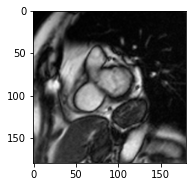

In [180]:
plt.subplot(121)
plt.imshow(im[0,:,:,:].astype("float32"))

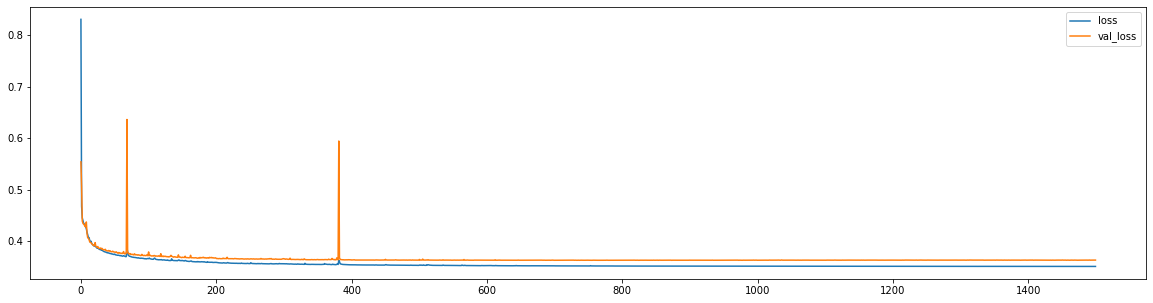

In [39]:
n = 0
plt.figure(figsize=(20,5))
plt.plot(hist.history["loss"][n:], label="loss")
plt.plot(hist.history["val_loss"][n:], label="val_loss")
plt.legend()

[0.81309824 0.21838272 0.40400171 0.62300598 0.7059388  0.94662184
 0.25463538 0.43189022 0.99182365 0.86305555]
[0.91957168 0.3465188  0.45116316 0.13884377 0.97735042 0.75179823
 0.10077926 0.80364806 0.15312118 0.6631572 ]
[0.11293162 0.44865339 0.12683959 0.53631563 0.35518164 0.38937002
 0.55806623 0.17579241 0.82005789 0.6993984 ]
[0.35838122 0.59846615 0.86766606 0.61315767 0.14494019 0.91610491
 0.0867704  0.90630638 0.59305847 0.75038869]


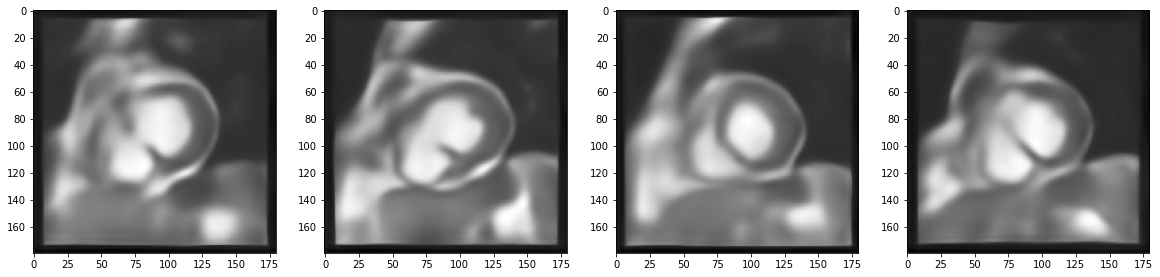

In [217]:
plt.figure(figsize=(20,10))
vector = np.random.rand(4,64)
for i in range(4):
    im = vector[i,:]
    imgen = cvae_model.decoder.predict(im[None,:])
#     print(imgen.shape)
    plt.subplot(1,4,1+i)
    print(im[:10])
    plt.imshow(imgen[0,:,:,0].astype("float32"))

In [224]:
# cvae_model.CVAE_model.save("cvae_model_20210918_keras.h5", save_format="tf")

In [123]:
a = next(ds.as_numpy_iterator())[0]

In [17]:
np.unique(a)

array([0.000e+00, 9.239e-06, 3.099e-05, ..., 6.333e-01, 6.338e-01,
       6.377e-01], dtype=float16)

In [9]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

model = tf.keras.models.load_model("./cvae_model_20210918_keras.h5", custom_objects={'Sampling': Sampling})

In [10]:
encoder = model.get_layer("encoder")
decoder = model.get_layer("decoder")

In [15]:
a[0].shape

0.739

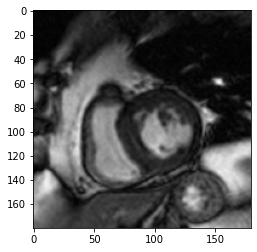

In [8]:
if "iterador" not in globals():
    iterador = ds_val.as_numpy_iterator()
# a = next(iterador)
plt.imshow(a[0].astype("float32"))
np.save("im.npy", a[0])

In [11]:
x = encoder.predict(a[0][None, :, :, :])

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node encoder/conv2d_597/Conv2D (defined at <ipython-input-11-c47db85ffa29>:1) ]] [Op:__inference_predict_function_11788]

Function call stack:
predict_function


In [12]:
 decoder.predict([[0.7 for x in range(64)]])

InternalError:  Blas GEMM launch failed : a.shape=(1, 64), b.shape=(64, 2304), m=1, n=2304, k=64
	 [[node decoder/dense_80/MatMul (defined at <ipython-input-12-8c920a96cd53>:1) ]] [Op:__inference_predict_function_12187]

Function call stack:
predict_function
